In [11]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit

## Laplaces Equation in 2D

$$\nabla^2 V=0$$

$$\frac{\partial^2 V}{\partial x^2}+\frac{\partial^2 V}{\partial y^2}=0$$

This equation can be discretised as

$$\frac{V(x_{i+1}, y_j) - 2V(x_i, y_j) + V(x_{i-1}, y_j)}{(\Delta x)^2} + \frac{V(x_i, y_{j+1}) - 2V(x_i, y_j) + V(x_i, y_{j-1})}{(\Delta y)^2} = 0 $$

Let $ \Delta x = \Delta y$, $V(x_i, y_j)$ can be written as

$$V(x_i, y_j) = \frac{1}{4}(V(x_{i+1}, y_{j}) + V(x_{i-1}, y_{j}) + V(x_{i}, y_{j+1}) + V(x_{i}, y_{j-1}))$$


In [ ]:
@numba.jit("f8[:,:](f8[:,:], i8)", nopython=True, nogil=True)
def compute_potential(potential, n_iter):
    length = len(potential[0])
    for n in range(n_iter):
        for i in range(1, length-1):
            for j in range(1, length-1):
                potential[j][i] = 1/4 * (potential[j+1][i] + potential[j-1][i] + potential[j][i+1] + potential[j][i-1])
    return potential

## Numba 

**Numba** is a Just-In-Time (JIT) compiler that speeds up numerical Python by compiling selected functions to fast machine code (via LLVM). It works best with loops and NumPy arrays.

### `@numba.jit`
- Decorator that asks Numba to compile a function.
- Two common styles:
  - **Type-inferred**: `@jit(nopython=True)` — Numba infers types on first call.
  - **Typed signature**: `@jit("f8[:,:](f8[:,:], i8)", nopython=True, nogil=True)` — state exact input/output types up front (faster compilation, clearer intent).

### Useful options
- `nopython=True`: compile entirely to native code (fastest); error if unsupported Python objects appear.
- `nogil=True`: release the Python GIL while running (better thread concurrency).
- `parallel=True`: enable multi-threaded loops with `numba.prange`.

### Signature `f8[:,:](f8[:,:], i8)`

| Piece | Meaning |
|------|---------|
| `f8` | 64-bit float (`float64`) |
| `i8` | 64-bit int (`int64`) |
| `[:]` / `[:,:]` | 1D / 2D NumPy array (contiguous or strided) |
| `f8[:,:](f8[:,:], i8)` | **Return type** is a 2D `float64` array; **arguments** are (2D `float64` array, `int64`) |

So the function **takes** a 2D float64 array and an int64, and **returns** a 2D float64 array.

In [13]:
size = 100
edge = np.linspace(-1, 1, size)
xv, yv = np.meshgrid(edge, edge)

upper_y = 0
lower_y = 0
upper_x = 0
lower_x = 1

In [15]:
initial_potential = np.zeros((size,size))

# Boundary conditions
initial_potential [0,:]= lower_y
initial_potential [-1,:]= upper_y
initial_potential [:,0]= lower_x
initial_potential [:,-1]= upper_x

potential = compute_potential(initial_potential , n_iter=10000)

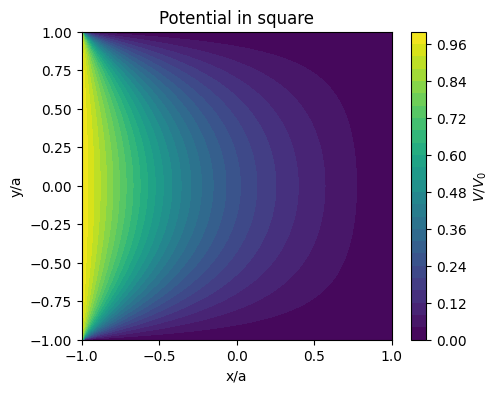

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
clr_plot = ax.contourf(xv, yv, potential, 30)
ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(clr_plot, label='$V/V_0$')
ax.set_title('Potential in square')
plt.show()

### Insert a shape of fixed potential
Define a shape which is set at a constant potential

In [36]:
# Define a function to create a circular block potential
def potential_block(x, y, R):
    r = np.sqrt(x**2 + y**2)
    return np.select([(r <= R),(r > R)],[1,0])
    

Obtain the fixed potential, and the places where the potential is fixed. (Do not modify inside this area)

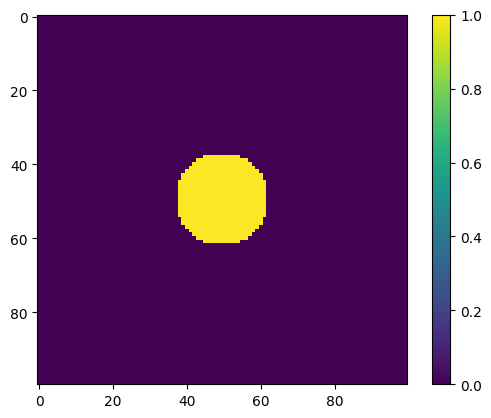

In [37]:
fixed = potential_block(xv,yv,0.25)
fixed_bool = fixed != 0. #change (1, 0) to (True, false)
plt.imshow(fixed_bool)
plt.colorbar()

In [ ]:
@numba.jit("f8[:,:](f8[:,:], i8, b1[:,:])", nopython=True, nogil=True)
def compute_potential(potential, n_iter, fixed_bool):
    h, w = potential.shape
    for _ in range(n_iter):
        for j in range(1, h-1):
            for i in range(1, w-1):
                if not fixed_bool[j, i]:
                    potential[j, i] = 1/4 * (
                        potential[j+1, i] + potential[j-1, i] +
                        potential[j, i+1] + potential[j, i-1]
                    )
    return potential

In [39]:
potential = np.ones((100,100))*0.1 # initial potential V = 0.1 everywhere

potential[0,:]= lower_y
potential[-1,:]= upper_y
potential[:,0]= lower_x
potential[:,-1]= upper_x
potential[fixed_bool] = fixed[fixed_bool]

potential = compute_potential(potential, n_iter=10000, fixed_bool=fixed_bool )

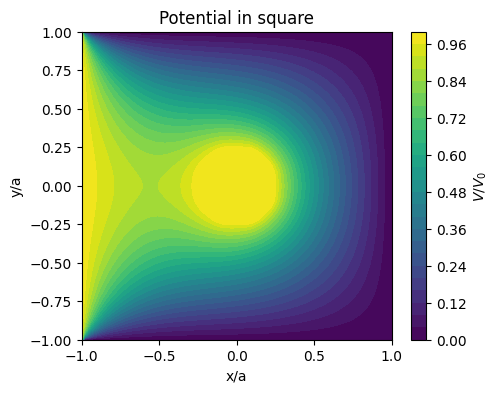

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
clr_plot = ax.contourf(xv, yv, potential, 30)
ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(clr_plot, label='$V/V_0$')
ax.set_title('Potential in square')
plt.show()